Bank Loses 3,000 USD for every wrong approval and makes 1,000 USD for every accurate approval

In [ ]:
!pip install xgboost

#Libraries and setup

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Reading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read input file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Loan Approval Classification/loan_data.csv')

#Exploring Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [ ]:
# rename columns to ease of use:
new_cols_names = ['age', 'gender', 'education', 'income',
       'emp_exp', 'home_ownership', 'loan_amnt', 'loan_intent',
       'int_rate', 'loan_percent_income', 'cred_hist_length',
       'credit_score', 'previous_defaults', 'approval_status']

df.columns = new_cols_names
df.columns

Index(['age', 'gender', 'education', 'income', 'emp_exp', 'home_ownership',
       'loan_amnt', 'loan_intent', 'int_rate', 'loan_percent_income',
       'cred_hist_length', 'credit_score', 'previous_defaults',
       'approval_status'],
      dtype='object')

In [ ]:
# convert income and loan amount to LOG income and LOG loan amount in order to compress the range of values
df['log_income'] = np.log(df['income'])
df['log_loan_amnt'] = np.log(df['loan_amnt'])
df.drop(labels = ['income', 'loan_amnt'], axis = 1, inplace = True)

In [ ]:
# Determine categorical and Numerical columns
categorical_cols = [col for col in df.columns if df[col].dtypes == 'object']
numerical_cols = [col for col in df.columns if df[col].dtypes != 'object']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45000 non-null  float64
 1   gender               45000 non-null  object 
 2   education            45000 non-null  object 
 3   emp_exp              45000 non-null  int64  
 4   home_ownership       45000 non-null  object 
 5   loan_intent          45000 non-null  object 
 6   int_rate             45000 non-null  float64
 7   loan_percent_income  45000 non-null  float64
 8   cred_hist_length     45000 non-null  float64
 9   credit_score         45000 non-null  int64  
 10  previous_defaults    45000 non-null  object 
 11  approval_status      45000 non-null  int64  
 12  log_income           45000 non-null  float64
 13  log_loan_amnt        45000 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB


#Exploratory Data Analysis

In [ ]:
# examine the high-level statistics of the numerical columns
df.describe()

,age,emp_exp,int_rate,loan_percent_income,cred_hist_length,credit_score,approval_status,log_income,log_loan_amnt
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,5.410333,11.006606,0.139725,5.867489,632.608756,0.222222,11.122440,8.940948
std,6.045108,6.063532,2.978808,0.087212,3.879702,50.435865,0.415744,0.557513,0.710887
min,20.000000,0.000000,5.420000,0.000000,2.000000,390.000000,0.000000,8.987197,6.214608
25%,24.000000,1.000000,8.590000,0.070000,3.000000,601.000000,0.000000,10.762234,8.517193
50%,26.000000,4.000000,11.010000,0.120000,4.000000,640.000000,0.000000,11.113164,8.987197
75%,30.000000,8.000000,12.990000,0.190000,8.000000,670.000000,0.000000,11.469906,9.412240
max,144.000000,125.000000,20.000000,0.660000,30.000000,850.000000,1.000000,15.789698,10.463103


Checking the dataset for represenation bias in gender

In [ ]:
df['gender'].value_counts(normalize=True)

,proportion
gender,
male,0.552022
female,0.447978


In [ ]:
df.groupby('gender')['approval_status'].value_counts(normalize=True)

gender  approval_status
female  0                  0.777519
        1                  0.222481
male    0                  0.777988
        1                  0.222012
Name: proportion, dtype: float64

In [ ]:
df.groupby('gender')['education'].value_counts(normalize=True)

gender  education  
female  Bachelor       0.298527
        Associate      0.266134
        High School    0.264944
        Master         0.156754
        Doctorate      0.013642
male    Bachelor       0.297130
        Associate      0.268226
        High School    0.266938
        Master         0.153778
        Doctorate      0.013929
Name: proportion, dtype: float64

In [ ]:
df.groupby('gender')['loan_intent'].value_counts(normalize=True)

gender  loan_intent      
female  EDUCATION            0.202341
        MEDICAL              0.192718
        VENTURE              0.173124
        PERSONAL             0.168362
        DEBTCONSOLIDATION    0.157299
        HOMEIMPROVEMENT      0.106156
male    EDUCATION            0.204259
        MEDICAL              0.187714
        VENTURE              0.174268
        PERSONAL             0.167385
        DEBTCONSOLIDATION    0.159977
        HOMEIMPROVEMENT      0.106397
Name: proportion, dtype: float64

In [ ]:
df.groupby('gender')['home_ownership'].value_counts(normalize=True)

gender  home_ownership
female  RENT              0.521950
        MORTGAGE          0.410487
        OWN               0.065083
        OTHER             0.002480
male    RENT              0.520148
        MORTGAGE          0.411175
        OWN               0.065980
        OTHER             0.002697
Name: proportion, dtype: float64

The data set seems to be balanced between genders. The gender split in the dataset is failry equal (55/45). in addtion, the split of each gender in loan approval, education, and loan intent seems equitable

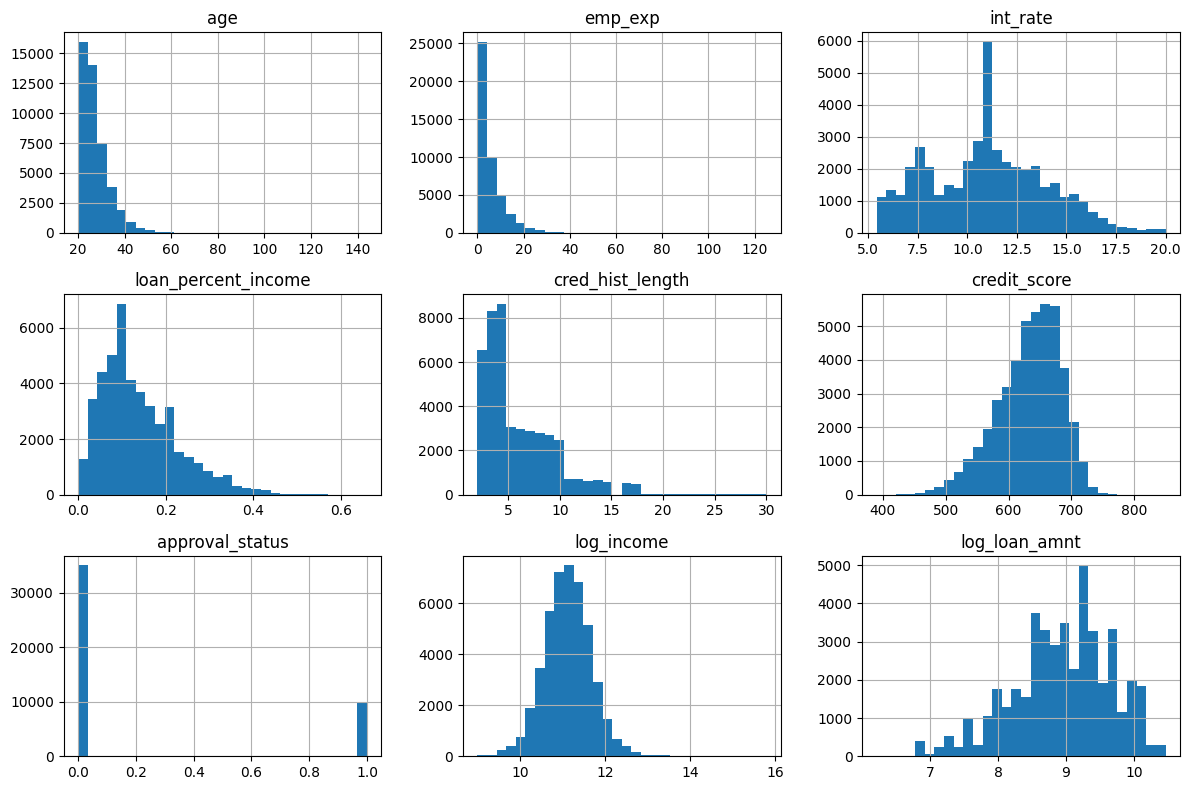

In [ ]:
# Analyzing the distribution of numerical columns in the dataset

# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

# Iterate over numerical columns and plot histograms
for i, col in enumerate(df[numerical_cols].columns):
    row = i // 3
    column = i % 3
    df.hist(column=col, bins=30, ax=axes[row, column])
    axes[row, column].set_title(col)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

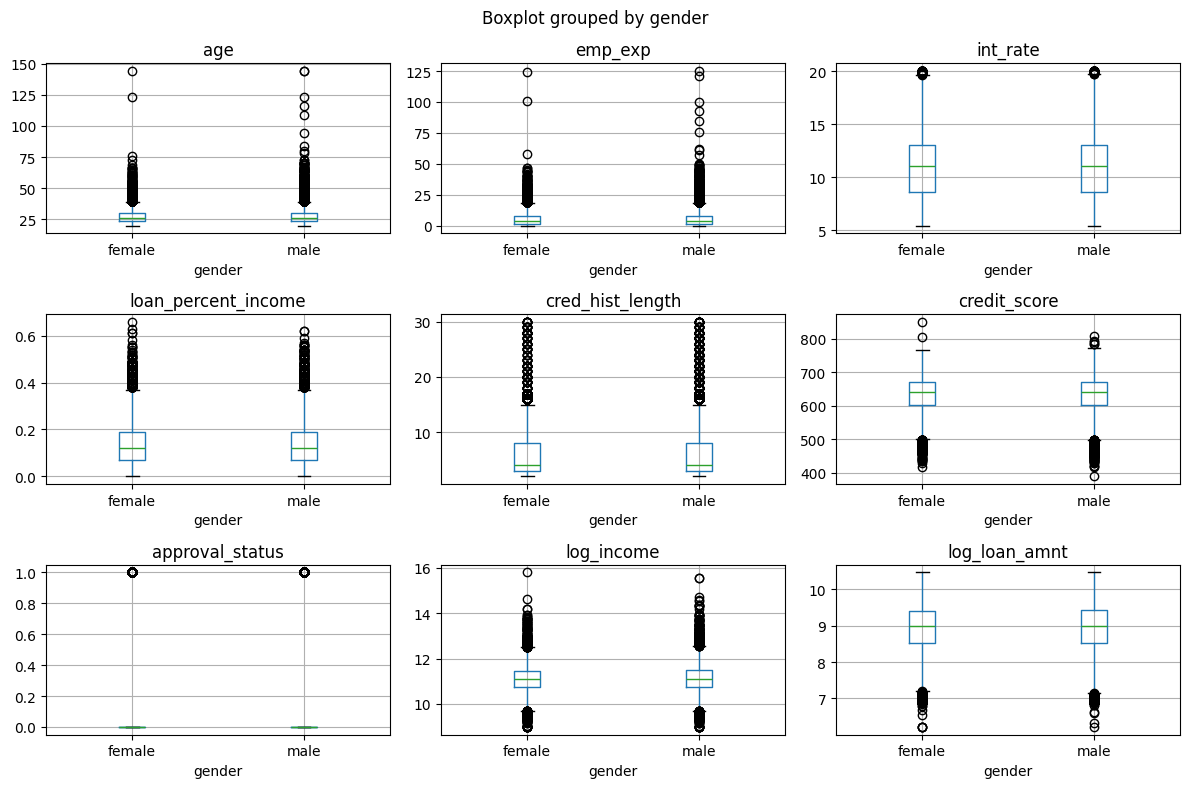

In [ ]:
# Analyzing the distribtion of the numerical values for both males and female applicants

# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

# Iterate over numerical columns and plot boxplots for each gender
for i, col in enumerate(df[numerical_cols].columns):
    row = i // 3
    column = i % 3
    df.boxplot(column=col, by='gender', ax=axes[row, column])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# sns.pairplot(df)

In [ ]:
# We will be evaluating multiple predictive models for this dataset. To organize the results, we will create a master dataframe to store the performance data for each model:
model_performance_df = pd.DataFrame(columns=['model name', 'model description','accuracy', 'roc auc', 'precision', 'recall', 'f1 score', 'optimal threshold', 'profit per applicant'])

#Helper Functions

In [ ]:
def calculate_metrics(y_true, y_pred):
    '''
    the function caclulates evaluation metrics for a given y_true and y_pred, including:
    accuracy score, roc_auc_score, percision, recall, and F1 score
    '''
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract values from the confusion matrix
    # cm[1,1] = True Positives (TP)
    # cm[0,1] = False Positives (FP)
    # cm[0,0] = True Negatives (TN)
    # cm[1,0] = False Negatives (FN)

    tn, fp, fn, tp = cm.ravel()

    precision = tp / (fp + tp) if (fp + tp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1_score = 2* ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

    return accuracy, roc_auc, precision, recall, f1_score

In [ ]:
def print_metrics(model, accuracy, roc_auc, precision, recall, f1_score):
    '''
    Prints evaluation scores for a the given model.
    scores include accuracy, roc_auc, precision, recall, and f1 score
    '''
    print(f'accuracy score for {model.__class__.__name__} is: {accuracy:.3f}')
    print(f'roc_auc score for {model.__class__.__name__} is: {roc_auc:.3f}')
    print(f'precision score for {model.__class__.__name__} is: {precision:.3f}')
    print(f'recall score for {model.__class__.__name__} is: {recall:.3f}')
    print(f'f1 score for {model.__class__.__name__} is: {f1_score:.3f}')

In [ ]:
def make_predictions (models, x_train, x_test, y_train, y_test):
    '''
    receives a list of predictive models.
    Returns a pandas dataframe with evaluation scores for all models in the list
    '''
    results = pd.DataFrame(columns = ['model_name', 'accuracy', 'roc_auc', 'precision', 'recall', 'f1_score'])

    for model in models:
        m = model.fit(x_train, y_train)
        p = m.predict(x_test)
        accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, p)
        new_row = pd.DataFrame({'model_name': [model.__class__.__name__], 'accuracy': [round(accuracy,3)], 'roc_auc': [round(roc_auc, 3)], 'precision': [round(precision, 3)], 'recall': [round(recall, 3)], 'f1_score': [round(f1_score, 3)]})
        results = pd.concat([results, new_row], ignore_index = True)
    return results



In [ ]:
def calculate_profit(y_true, y_pred, cutoff=0.5, is_probability=True):
    '''
    Calculates the expected profit-per-applicant.

    - For probability-predictions (e.g., Logistic Regression "predict_proba"), it takes predicted probabilities and a cutoff to determine classifications.
    - For non-probability based models (e.g., SVC "predict"), it takes direct class predictions and skips the cutoff processing.

    -- The calculation is based on the assumption the institution loses $3K for every wrong approval (False Positives),
       and profits $1K for every correct approval (True Positive).

    Returns:The expected profit per applicant (float)
    '''

    if is_probability:
        # For models that output probabilities, apply the cutoff
        y_classified_pred = np.where(y_pred >= cutoff, 1, 0)
    else:
        # For models that output direct class predictions, use them directly
        y_classified_pred = y_pred

    cm = confusion_matrix(y_true, y_classified_pred)

    # Extract values from the confusion matrix
    # cm[1,1] = True Positives (TP)
    # cm[0,1] = False Positives (FP)
    # cm[0,0] = True Negatives (TN)
    # cm[1,0] = False Negatives (FN)

    true_positives = cm[1, 1]
    false_positives = cm[0, 1]

    # Calculate profit
    expected_profit_per_applicant = (true_positives * 1000 - false_positives * 3000) / len(y_true)

    return expected_profit_per_applicant

In [ ]:
def create_profit_table(y_true, y_pred_proba, thresholds = np.arange(0,1.01,0.01)):
    '''
    Calculates the profit-per-applicant for each cutoff threshold given predicted probabilities, actual y values and set of cutoff thresholds.
    Returns a dataframe containing the expected profit per applicant and the corresponding threshold
    '''
    return pd.DataFrame({'threshold': thresholds,
                         'profit': [calculate_profit(y_true, y_pred_proba, threshold) for threshold in thresholds]})

In [ ]:
def find_best_profit_and_threshold(y_true, y_pred_proba):
    '''
    Returns a pandas series with the optimal cutoff threshold and corresponding profit-per-applicant, given predicted probabilities and actual y values.
    '''

    profit_table = create_profit_table(y_true, y_pred_proba)
    idx = profit_table['profit'].idxmax()

    return profit_table.loc[idx,:]

In [ ]:
def append_dataframe(model_name, model_description, accuracy, roc_auc, percision, recall, f1_score, optimal_threshold, profit_per_applicant):
      '''
      Creates a new row for the model performance dataframe and appends it to the global dataframe
      '''
      global model_performance_df
      # Create a new row for the DataFrame
      new_row = {
        'model name': model_name,
        'model description': model_description,
        'accuracy': accuracy,
        'roc auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1 score': f1_score,
        'optimal threshold': optimal_threshold,
        'profit per applicant': profit_per_applicant}

      #Append the new row to the global DataFrame
      model_performance_df = pd.concat([model_performance_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
def prepare_data(df, drop_first = False):
    '''
    prepares the training and testing datasets: Grenerates dummies, splits data, and scales columns.
    Returns X_train, X_test, y_train, y_test
    '''
    # Copy the original dataframe to preserve its integrity
    df_copy = df.copy()

    #Determine categorical and Numerical columns
    categorical_cols = [col for col in df_copy.columns if df_copy[col].dtypes == 'object']
    numerical_cols = [col for col in df_copy.columns if df_copy[col].dtypes != 'object']

    #Generate Dummy Variables
    if categorical_cols:
        df_copy[categorical_cols] = df_copy[categorical_cols].astype('category')
        df_copy = pd.get_dummies(df_copy,columns=categorical_cols, dtype='int', drop_first = drop_first)

    #Identify Dependant and Independant Variables and generate training and testing sets
    X = df_copy.drop(['approval_status'], axis = 1)
    y = df_copy['approval_status']

    #Split the data into training and testing sets. Enable "stratify" to maintian class proportion in the training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, stratify=y, random_state = 42)

    #Scale Data
    scaler = StandardScaler()
    scaler.set_output(transform = 'pandas')

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    return df_copy, X_train, X_test, y_train, y_test

In [ ]:
#Create a helper function to visualize the tree
def viz_tree(tree, df, font=12, figsize=(16,10)):
  '''
  draws a classification tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=df.columns,
                filled=True,
                fontsize=font)

#Data Prep

In [ ]:
#prepare data for the logistic regression model
df_dummies_dropfirst, X_train, X_test, y_train, y_test = prepare_data(df, drop_first = True)

In [ ]:
df_dummies_dropfirst.describe()

,age,emp_exp,int_rate,loan_percent_income,cred_hist_length,credit_score,approval_status,log_income,log_loan_amnt,gender_male,education_Bachelor,education_Doctorate,education_High School,education_Master,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_defaults_Yes
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,5.410333,11.006606,0.139725,5.867489,632.608756,0.222222,11.122440,8.940948,0.552022,0.297756,0.013800,0.266044,0.155111,0.002600,0.065578,0.520956,0.203400,0.106289,0.189956,0.167822,0.173756,0.507956
std,6.045108,6.063532,2.978808,0.087212,3.879702,50.435865,0.415744,0.557513,0.710887,0.497292,0.457277,0.116661,0.441893,0.362015,0.050924,0.247545,0.499566,0.402532,0.308210,0.392270,0.373712,0.378903,0.499942
min,20.000000,0.000000,5.420000,0.000000,2.000000,390.000000,0.000000,8.987197,6.214608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.000000,8.590000,0.070000,3.000000,601.000000,0.000000,10.762234,8.517193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,4.000000,11.010000,0.120000,4.000000,640.000000,0.000000,11.113164,8.987197,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,30.000000,8.000000,12.990000,0.190000,8.000000,670.000000,0.000000,11.469906,9.412240,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,144.000000,125.000000,20.000000,0.660000,30.000000,850.000000,1.000000,15.789698,10.463103,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_dummies_dropfirst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          45000 non-null  float64
 1   emp_exp                      45000 non-null  int64  
 2   int_rate                     45000 non-null  float64
 3   loan_percent_income          45000 non-null  float64
 4   cred_hist_length             45000 non-null  float64
 5   credit_score                 45000 non-null  int64  
 6   approval_status              45000 non-null  int64  
 7   log_income                   45000 non-null  float64
 8   log_loan_amnt                45000 non-null  float64
 9   gender_male                  45000 non-null  int64  
 10  education_Bachelor           45000 non-null  int64  
 11  education_Doctorate          45000 non-null  int64  
 12  education_High School        45000 non-null  int64  
 13  education_Master

In [ ]:
#develop base model by taking the most common class in the dataset "0", and establish baseline performance metrics
#create new column with most common loan outcome value "0"
df_dummies_dropfirst['base_predict'] = 0

#Generate the baseline metrics using the helper function
accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(df_dummies_dropfirst['approval_status'], df_dummies_dropfirst['base_predict'])

print(f'base model roc_auc is: {roc_auc}')
print(f'base model precision is: {precision}')
print(f'base model recall is: {recall}')
print(f'base model f1 score is: {f1_score}')

base model roc_auc is: 0.5
base model precision is: 0
base model recall is: 0.0
base model f1 score is: 0


We can see from the metrics above that the base model is not better than a random guess. Moreover, the 0s for precision, recall, and f1 score is due to the fact that the base prediciton is 0 for all cases, meaning there are no positive class predictions in the base model,  hence, no True positives.

In [ ]:
#Examining the training dataset
X_train.describe()

,age,emp_exp,int_rate,loan_percent_income,cred_hist_length,credit_score,log_income,log_loan_amnt,gender_male,education_Bachelor,education_Doctorate,education_High School,education_Master,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_defaults_Yes
count,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04,3.375000e+04
mean,1.121736e-16,2.760590e-17,-9.473903e-17,-2.589534e-16,6.358042e-17,2.385845e-16,-1.468034e-15,2.140260e-15,5.158014e-17,1.389506e-16,-1.263187e-17,2.084259e-17,-2.779012e-17,-5.894873e-18,-1.031603e-17,8.163347e-17,-3.200074e-17,2.621113e-17,-8.842310e-18,5.936979e-17,-6.315935e-18,1.042129e-17
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-1.284468e+00,-8.918297e-01,-1.881270e+00,-1.605432e+00,-9.974921e-01,-4.827425e+00,-3.817183e+00,-3.843952e+00,-1.104186e+00,-6.540995e-01,-1.190947e-01,-5.974966e-01,-4.279867e-01,-5.256586e-02,-2.654112e-01,-1.040709e+00,-5.037010e-01,-3.446872e-01,-4.849980e-01,-4.477859e-01,-4.577161e-01,-1.013303e+00
25%,-6.230352e-01,-7.269718e-01,-8.152833e-01,-8.013889e-01,-7.392311e-01,-6.094114e-01,-6.434644e-01,-6.013750e-01,-1.104186e+00,-6.540995e-01,-1.190947e-01,-5.974966e-01,-4.279867e-01,-5.256586e-02,-2.654112e-01,-1.040709e+00,-5.037010e-01,-3.446872e-01,-4.849980e-01,-4.477859e-01,-4.577161e-01,-1.013303e+00
50%,-2.923189e-01,-2.323983e-01,-1.501623e-03,-2.270721e-01,-4.809700e-01,1.466478e-01,-1.870280e-02,6.049980e-02,9.056445e-01,-6.540995e-01,-1.190947e-01,-5.974966e-01,-4.279867e-01,-5.256586e-02,-2.654112e-01,9.608830e-01,-5.037010e-01,-3.446872e-01,-4.849980e-01,-4.477859e-01,-4.577161e-01,9.868714e-01
75%,3.691137e-01,4.270331e-01,6.744080e-01,5.769714e-01,5.520741e-01,7.435365e-01,6.321882e-01,6.605261e-01,9.056445e-01,1.528819e+00,-1.190947e-01,1.673650e+00,-4.279867e-01,-5.256586e-02,-2.654112e-01,9.608830e-01,-5.037010e-01,-3.446872e-01,-4.849980e-01,-4.477859e-01,-4.577161e-01,9.868714e-01
max,1.921994e+01,1.971540e+01,3.021596e+00,5.975549e+00,6.233817e+00,4.324869e+00,8.332505e+00,2.138921e+00,9.056445e-01,1.528819e+00,8.396680e+00,1.673650e+00,2.336521e+00,1.902375e+01,3.767739e+00,9.608830e-01,1.985305e+00,2.901181e+00,2.061864e+00,2.233210e+00,2.184760e+00,9.868714e-01


#Data Modeling

## 1. Logistic Regression

In [ ]:
#Create an initial logistic regression model:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train,y_train)

y_predict = model_lr.predict(X_test)

accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_lr, accuracy, roc_auc, precision, recall, f1_score)

accuracy score for LogisticRegression is: 0.904
roc_auc score for LogisticRegression is: 0.855
precision score for LogisticRegression is: 0.792
recall score for LogisticRegression is: 0.768
f1 score for LogisticRegression is: 0.780


In [ ]:
print('profit-per-applicant for the initial regression model is: $%.2f' %(calculate_profit(y_test, y_predict, is_probability=False)))

profit-per-applicant for the initial regression model is: $36.36


In [ ]:
#appending the summary dataframe with the information for the new model (threshold is 0 since this is a class prediction with not probabilities ):
append_dataframe(model_lr.__class__.__name__, "initial logistic regression model", accuracy, roc_auc, precision, recall, f1_score, 0, calculate_profit(y_test, y_predict, is_probability=False))
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.8554,0.792165,0.7684,0.780102,0,36.355556


The performance metrics of the initial logisitc regression model are very pormising and it generates a net positive expected profit! Let's see if we can further improve it.
<br>
<br>
<br>

Text(0, 0.5, 'F1 Score')

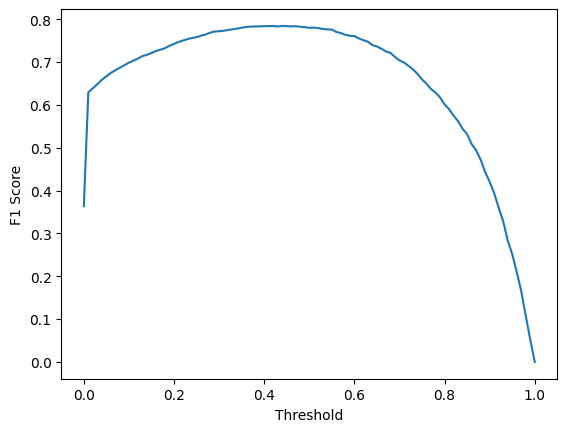

In [ ]:
#find the optimal threshld to maximize the profit per applicant:

#Refine the logistic regression model by predicting class probabilties then finding the optimal classificaiton threshold to maximize performance:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train,y_train)

y_predict_proba = model_lr.predict_proba(X_test)

#Determine the optimal threshold to predict loan approval (class "1") by finding the classificaiton threshold that yeilds the highest f1 score.
#The classificaiton threshold will start at 0 and increase by 1% up to 100%
thresholds = np.arange(0,1.01,0.01)
f1_all = []

#iterate over the thresholds and calcualte the f1 score for each
for t in thresholds:
    y_predict = np.where(y_predict_proba[:,1] >= t,1,0)
    _, __, ___, ____, f1_score = calculate_metrics(y_test, y_predict)

    f1_all.append(f1_score)

#Plot the f1 score against the corresponding thresholds
plt.plot(thresholds,f1_all)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')



In [ ]:
#find the classificaiton threshold with the highest f1 score
max_threshold = thresholds[f1_all.index(max(f1_all))]
print('The threhsold with the highest f1 score is: %.2f' %(max_threshold))

The threhsold with the highest f1 score is: 0.44


In [ ]:
#evaulate performance of Logistic Regression Model at the optimal threshold [0.44]
y_predict = np.where(y_predict_proba[:,1] > max_threshold,1,0)

accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_lr, accuracy, roc_auc, precision, recall, f1_score)

accuracy score for LogisticRegression is: 0.902
roc_auc score for LogisticRegression is: 0.868
precision score for LogisticRegression is: 0.763
recall score for LogisticRegression is: 0.807
f1 score for LogisticRegression is: 0.785


At the optimal threshold for F1-Score, we improved scores for roc_auc, recall, and f1 score. However, the tradeoff was a lower score for both percsion and accuracy.

The optimal threshold for the f1 score likely improved recall, which might have come at the expense of percision. In tuen, the decrease in percision, might have affected the accuracy.

The increase in F1 score and recall, along with better ROC AUC, suggests that (at the optimal threshold) the model is performing better in terms of its ability to detect the positive class, but with potentially more false positives.

Ultimately, profitability is going to be most important in determining the value of the model to the business. So we will use that to determine if the model is indeed better at the optimal threshold

Text(0, 0.5, 'profit-per-applicant')

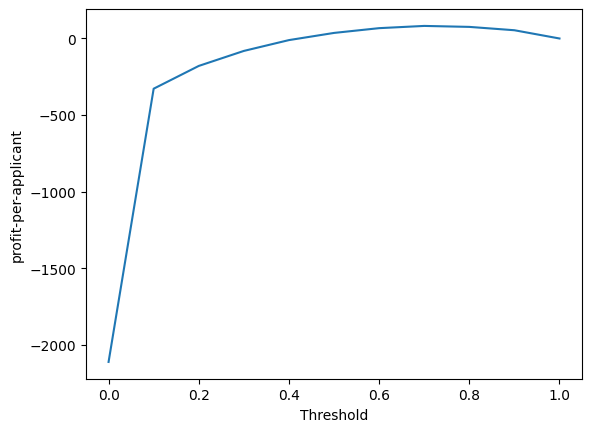

In [ ]:
#Now we will determine which classificaiton threhsold is most profitable for the organization.
#Remember, every accurate prediction yields $1000, and every wrong prediction loses $3000

#Refine the logistic regression model by predicting class probabilties then finding the optimal classificaiton threshold to maximize performance:
model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)

y_predict_proba = model_lr.predict_proba(X_test)

#Determine the optimal threshold to predict loan approval (class "1") by finding the threshold that yeilds the highest f1 score
profit_thresholds = np.arange(0,1.1,0.1)
profit_all = []

for t in profit_thresholds:
    profit_all.append(calculate_profit(y_test, y_predict_proba[:,1], cutoff = t, is_probability=True))


plt.plot(profit_thresholds,profit_all)
plt.xlabel('Threshold')
plt.ylabel('profit-per-applicant')

In [ ]:
#find the profit per customer and
best  = find_best_profit_and_threshold(y_test, y_predict_proba[:,1])
print('The best threhsold is: %.2f; it corresponds to an expected profit-per-applicant of: $%.2f' % (best['threshold'], best['profit']))

The best threhsold is: 0.68; it corresponds to an expected profit-per-applicant of: $82.13


In [ ]:
#appending the summary dataframe with the information for the new model:
append_dataframe(model_lr.__class__.__name__, "optimized logistic regression model at the optimal profit threshold", accuracy, roc_auc, precision, recall, f1_score, best['threshold'], best['profit'])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333


In [ ]:
# Create List of Models:
#model_lr = LogisticRegression() -- DONE
#model_svc = SVC() -- DONE
#model_dtc = DecisionTreeClassifier()
#model_rfc = RandomForestClassifier()
#model_xgb = xgb.XGBClassifier()

At an average profit per applicant of 82 USD, the optimized logistic regression model is significant improvement on the initial logistic regression models , which had an averge profit per applicant of around 36 USD.

We will now experiment with other models to see if we can improve the performance of the predictions and profitability using decision tree models.

## 2. Decision Tree Classifier (CART)

In [ ]:
# since the next models are tree models, we will create a new version of the dummy variables without dropping the reference category.
# Then we will create the new training and testing sets
df_dummies_keepfirst, X_train, X_test, y_train, y_test = prepare_data(df, drop_first = False)

In [ ]:
#Create a simple decsion tree classifier model
model_dtc = DecisionTreeClassifier(random_state=42)
model_dtc.fit(X_train, y_train)

y_predict = model_dtc.predict(X_test)

accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_dtc, accuracy, roc_auc, precision, recall, f1_score)
print('profit-per-applicant for the dtc model is: $%.2f' %(calculate_profit(y_test, y_predict, is_probability=False)))

accuracy score for DecisionTreeClassifier is: 0.899
roc_auc score for DecisionTreeClassifier is: 0.857
precision score for DecisionTreeClassifier is: 0.770
recall score for DecisionTreeClassifier is: 0.782
f1 score for DecisionTreeClassifier is: 0.776
profit-per-applicant for the dtc model is: $17.69


In [ ]:
#appending the summary dataframe with the information for the new model (threshold is 0 since this is a class prediction with not probabilities ):
append_dataframe(model_dtc.__class__.__name__, "initial CART model", accuracy, roc_auc, precision, recall, f1_score, 0, calculate_profit(y_test, y_predict, is_probability=False))
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889


In [ ]:
#Finding the best threshold for the decision tree classifier

y_predict_proba_dtc = model_dtc.predict_proba(X_test)[:,1]
best  = find_best_profit_and_threshold(y_test, y_predict_proba_dtc)
print('The best threhsold is: %.2f; it corresponds to an expected profit-per-applicant of: $%.2f' % (best['threshold'], best['profit']))

The best threhsold is: 0.01; it corresponds to an expected profit-per-applicant of: $17.69


In [ ]:
#evaulate performance of the tree cliassifier at the optimal threshold [0.01]
y_predict = np.where(y_predict_proba[:,1] > best['threshold'],1,0)

accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_lr, accuracy, roc_auc, precision, recall, f1_score)

accuracy score for LogisticRegression is: 0.739
roc_auc score for LogisticRegression is: 0.832
precision score for LogisticRegression is: 0.460
recall score for LogisticRegression is: 1.000
f1 score for LogisticRegression is: 0.630


In [ ]:
#appending the summary dataframe with the information for the new model:
append_dataframe(model_dtc.__class__.__name__, "Initial CART model at optimal profit threhsold", accuracy, roc_auc, precision, recall, f1_score, best['threshold'], best['profit'])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889


The intial tree model seems to be worse that the first 2 model in terms of performance metrics and profitability. We will proceed to refine the tree model and see if we can get a jump in performance
<br>
<br>
<br>

In [ ]:
# With the default settings of the hyperparamters, CART model can easily overfit the data. a quick way to check for overfitting is to see how big the tree is
print('# of levels in the decision tree is: %.0f\n# of nodes in the dicsion tree is: %.0f'% (model_dtc.tree_.max_depth, model_dtc.tree_.node_count))

# of levels in the decision tree is: 30
# of nodes in the dicsion tree is: 4149


This is a huge tree: 30 levels deep with over 4000 nodes. We will prune this tree using **cost-complexity pruning** and see if we can mitigage overfitting

In [ ]:
# getting the ccp_alpha for the tree
path = model_dtc.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

In [ ]:
# Checking the number of trees since every ccp alphas correpsonsde to a different tree
len(alphas)

968

In [ ]:
# 968 is a large number of trees. To prevent excessive processing time, we will generate about 90 trees, evenly sampled from the population

small_alphas = alphas[::10] #Picks every 10th alpha
small_alphas = small_alphas[::-1] # reverses the order of the list to start with the heigest alpha (the higher the alpha, the smaller the tree)

In [ ]:
len(small_alphas)

97

In [ ]:
# Generate the trees

trees = []

for alpha in small_alphas:
  tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
  tree.fit(X_train, y_train)
  trees.append(tree)

In [ ]:
print('this process generated %.0f trees'% (len(trees)))

this process generated 97 trees


In [ ]:
#Helper function to get the best profit and the threshold for each of the 97 trees
def all_trees_profits_thresholds(X,y):
  max_profit = []
  best_threshold = []
  for tree in trees:
    y_pred = tree.predict_proba(X)[:,1]
    pf = find_best_profit_and_threshold(y, y_pred)
    max_profit.append(pf['profit'])
    best_threshold.append(pf['threshold'])
  return max_profit, best_threshold

In [ ]:
#running the train and test datasets to get the values and visualze results
train_profits, train_thresholds = all_trees_profits_thresholds(X_train, y_train)
test_profits, test_thresholds = all_trees_profits_thresholds(X_test, y_test)

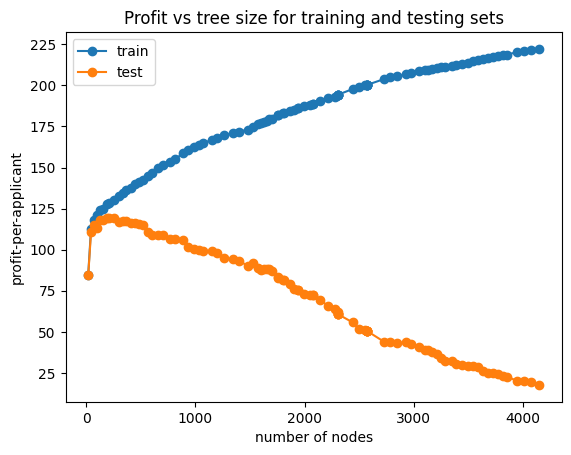

In [ ]:
#graphing the performance of the model on training and test datasets

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel('number of nodes')
ax.set_ylabel('profit-per-applicant')
ax.set_title('Profit vs tree size for training and testing sets')
ax.plot(node_counts, train_profits, marker = 'o', label = 'train')
ax.plot(node_counts, test_profits, marker = 'o', label = 'test')
ax.legend()
plt.show()

We can se from the scatterplot that profit seems to be higher at the beginning of the chart, before overfitting starts to set in as the number of nodes increases.  We will zoom in on the left most section of the chart (first 50 trees) to get a closer look.
<br>
<br>

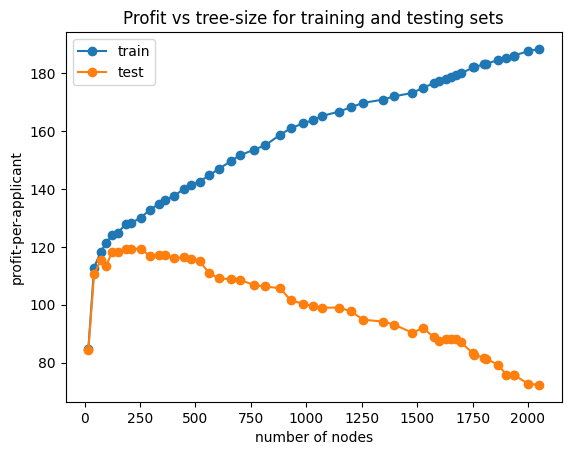

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('number of nodes')
ax.set_ylabel('profit-per-applicant')
ax.set_title('Profit vs tree-size for training and testing sets')
ax.plot(node_counts[:50], train_profits[:50], marker = 'o', label = 'train')
ax.plot(node_counts[:50], test_profits[:50], marker = 'o', label = 'test')
ax.legend()
plt.show()

We can see that the profit per applicant for the test data get to about 120 USD before tapring down. Let's find that optimal number of nodes.
<br>
<br>
<br>

In [ ]:
# find the optimal number of nodes

optimal_idx = np.argmax(test_profits)
print('Profit-per-applicant of the best tree is: $%.2f' % (test_profits[optimal_idx]))
print('Size of the best tree is %.0f nodes' % (node_counts[optimal_idx]))
print('Optimal Threshold for the best tree is: %.2f' %(test_thresholds[optimal_idx]))

Profit-per-applicant of the best tree is: $119.38
Size of the best tree is 253 nodes
Optimal Threshold for the best tree is: 0.82


In [ ]:
#calculating other performance metrics for the optimized tree

y_predict_proba = trees[optimal_idx].predict_proba(X_test)

y_predict = np.where(y_predict_proba[:,1] >= test_thresholds[optimal_idx],1,0)

# Calculating Performance metrics
accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(trees[optimal_idx], accuracy, roc_auc, precision, recall, f1_score)

accuracy score for DecisionTreeClassifier is: 0.907
roc_auc score for DecisionTreeClassifier is: 0.800
precision score for DecisionTreeClassifier is: 0.964
recall score for DecisionTreeClassifier is: 0.606
f1 score for DecisionTreeClassifier is: 0.744


In [ ]:
#appending the summary dataframe with the information for the new model:
append_dataframe(trees[optimal_idx].__class__.__name__, "Pruned CART model at optimal profit threshold", accuracy, roc_auc, precision, recall, f1_score, test_thresholds[optimal_idx], test_profits[optimal_idx])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778


In [ ]:
#viz_tree(model_dtc, df_dummies_keepfirst)

The optimized CART model has the highest profit-per-applicant at 119 USD, a significant improvement on the earlier models. It achieves that through high levels of precision, meaning it is very good at identifying true positives. And since the business rules have an imbalanced reward system where wrong predictions cost more than the reward for good predictions, the high precision / low recall perfomrance of CART model seems to yield the results that best fit that business objective.
<br>
<br>
<br>
<br>
We will continue to explore other models to if we can get even better results

## 3. Random Forest Classifier

In [ ]:
# Creating a random forest classifier
model_rfc = RandomForestClassifier(random_state=42, n_jobs = -1)
model_rfc.fit(X_train, y_train)

y_predict = model_rfc.predict(X_test)

# Calculating Performance metrics
accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_rfc, accuracy, roc_auc, precision, recall, f1_score)
print('profit-per-applicant for the rfc model is: $%.2f' %(calculate_profit(y_test, y_predict, is_probability=False)))

accuracy score for RandomForestClassifier is: 0.927
roc_auc score for RandomForestClassifier is: 0.869
precision score for RandomForestClassifier is: 0.894
recall score for RandomForestClassifier is: 0.763
f1 score for RandomForestClassifier is: 0.823
profit-per-applicant for the rfc model is: $109.51


In [ ]:
#appending the summary dataframe with the information for the new model:
append_dataframe(model_rfc.__class__.__name__, "initial random forest model", accuracy, roc_auc, precision, recall, f1_score, 0, calculate_profit(y_test, y_predict, is_probability=False))
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111


In [ ]:
#Finding the best threshold for the decision tree classifier

y_predict_proba_rfc = model_rfc.predict_proba(X_test)[:,1]
best  = find_best_profit_and_threshold(y_test, y_predict_proba_rfc)
print('The best threhsold is: %.2f; it corresponds to an expected profit-per-applicant of: $%.2f' % (best['threshold'], best['profit']))

The best threhsold is: 0.68; it corresponds to an expected profit-per-applicant of: $130.67


In [ ]:
#appending the summary dataframe with the information for the new model:
append_dataframe(model_rfc.__class__.__name__, "Random forest model at max profit threshold", accuracy, roc_auc, precision, recall, f1_score, best['threshold'], best['profit'])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111
6,RandomForestClassifier,Random forest model at max profit threshold,0.927289,0.868543,0.894465,0.7628,0.823402,0.68,130.666667


The random forest model seems to be a the best model so far with highest accuracy, f1 score, and profotability. Let's see if we can improve it even further. We will Use Random Search to tune the hyper parameters for the random search model.

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


# Set up RandomizedSearchCV
rcv = RandomizedSearchCV(estimator=model_rfc, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='f1', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
rcv.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", rcv.best_params_)

Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


In [ ]:
# Get the best model
best_rfc_model = rcv.best_estimator_
best_rfc_model

RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=10, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [ ]:
# Evaluate the best model
y_predict_proba = best_rfc_model.predict_proba(X_test)[:,1]

# Find the best threshold for the tuned model based on profit
best_tuned_profit = find_best_profit_and_threshold(y_test, y_predict_proba)
print('Optimal Threshold for the best tuned Random Forest model is: %.2f' %(best_tuned_profit[0]))
print('Profit-per-applicant of the best tuned Random Forest model is: $%.2f' % (best_tuned_profit[1]))

Optimal Threshold for the best tuned Random Forest model is: 0.68
Profit-per-applicant of the best tuned Random Forest model is: $131.20


In [ ]:
# Calculate performance metrics at the optimal profit threshold for the tuned model
y_predict = np.where(y_predict_proba >= best_tuned_profit['threshold'], 1, 0)

accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(best_rfc_model, accuracy, roc_auc, precision, recall, f1_score)

accuracy score for RandomForestClassifier is: 0.921
roc_auc score for RandomForestClassifier is: 0.830
precision score for RandomForestClassifier is: 0.963
recall score for RandomForestClassifier is: 0.668
f1 score for RandomForestClassifier is: 0.789


In [ ]:
# Append the results to the model_performance_df
append_dataframe(best_rfc_model.__class__.__name__, "Tuned Random Forest model at max profit threshold", accuracy, roc_auc, precision, recall, f1_score, best_tuned_profit['threshold'], best_tuned_profit['profit'])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111
6,RandomForestClassifier,Random forest model at max profit threshold,0.927289,0.868543,0.894465,0.7628,0.823402,0.68,130.666667
7,RandomForestClassifier,Tuned Random Forest model at max profit threshold,0.920533,0.830486,0.962558,0.6684,0.788952,0.68,131.200000


The optimized random forest tree seem to have slightly higher profitability at the same threhsold. However, it seem to score lower on all performance metrics but precision.

Let's try xgboost and see if it yields better performance

## 4. XGBoost Classifier

In [ ]:
# Creating an XGBoost classifier

#import module:
from xgboost import XGBClassifier

#Create evalaution set:
eval_set = [(X_test, y_test)]

#Create model:
model_xgb = XGBClassifier(objective='binary:logistic', learning_rate = 0.05, random_state = 42, max_depth= 20, gamma = 10, n_estimators = 500,
                          early_stopping_rounds = 20, eval_metric = 'auc')
model_xgb.fit(X_train, y_train, eval_set = eval_set, verbose = False)

y_predict = model_xgb.predict(X_test)



In [ ]:
# Calculating Performance metrics
accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(model_xgb, accuracy, roc_auc, precision, recall, f1_score)
print('profit-per-applicant for the XGBoost model is: $%.2f' %(calculate_profit(y_test, y_predict, is_probability=False)))

accuracy score for XGBClassifier is: 0.892
roc_auc score for XGBClassifier is: 0.788
precision score for XGBClassifier is: 0.870
recall score for XGBClassifier is: 0.602
f1 score for XGBClassifier is: 0.712
profit-per-applicant for the XGBoost model is: $73.60


In [ ]:
# Append the results to the model_performance_df
append_dataframe(model_xgb.__class__.__name__, "initial XGBoost Model", accuracy, roc_auc, precision, recall, f1_score, 0, calculate_profit(y_test, y_predict, is_probability=False))
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111
6,RandomForestClassifier,Random forest model at max profit threshold,0.927289,0.868543,0.894465,0.7628,0.823402,0.68,130.666667
7,RandomForestClassifier,Tuned Random Forest model at max profit threshold,0.920533,0.830486,0.962558,0.6684,0.788952,0.68,131.200000
8,XGBClassifier,initial XGBoost Model,0.891556,0.788286,0.869515,0.6024,0.711720,0,73.600000


The initial XGBoost model does not seem to outperform our best random forest classifier. However, it could be improved with hyperparameter tuning. Let's explor that next.

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': range(10,1010,10),
    'max_depth': range(1,51,1),
    'learning_rate': np.linspace(0.01, 1.0, 100),
    'scale_pos_weight': np.linspace(0.01, 1.0, 100),
    'gamma': np.linspace(0.01, 1.0, 100),
}

# Create an XGBoost classifier model
model_xgb_tuned = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, n_jobs=-1, early_stopping_rounds=20)


# Set up RandomizedSearchCV
rcv = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='f1', random_state=42, n_jobs=-1)


# Fit RandomizedSearchCV to the training data
rcv.fit(X_train, y_train, eval_set = eval_set, verbose = False)

# Print the best parameters found
print("Best parameters found: ", rcv.best_params_)

Best parameters found:  {'scale_pos_weight': np.float64(0.92), 'n_estimators': 560, 'max_depth': 8, 'learning_rate': np.float64(0.18000000000000002), 'gamma': np.float64(0.99)}


In [ ]:
best_xbg_model = rcv.best_estimator_

In [ ]:
#Generate predictions using the best estimator and evalaute performance:
y_pred = best_xbg_model.predict(X_test)

# Calculating Performance metrics
accuracy, roc_auc, precision, recall, f1_score = calculate_metrics(y_test, y_predict)
print_metrics(best_xbg_model, accuracy, roc_auc, precision, recall, f1_score)
print('profit-per-applicant for the XGBoost model is: $%.2f' %(calculate_profit(y_test, y_predict, is_probability=False)))


accuracy score for XGBClassifier is: 0.892
roc_auc score for XGBClassifier is: 0.788
precision score for XGBClassifier is: 0.870
recall score for XGBClassifier is: 0.602
f1 score for XGBClassifier is: 0.712
profit-per-applicant for the XGBoost model is: $73.60


In [ ]:
# Append the results to the model_performance_df
append_dataframe(best_xbg_model.__class__.__name__, "Tuned XGBoost model", accuracy, roc_auc, precision, recall, f1_score, 0, calculate_profit(y_test, y_predict, is_probability=False))
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111
6,RandomForestClassifier,Random forest model at max profit threshold,0.927289,0.868543,0.894465,0.7628,0.823402,0.68,130.666667
7,RandomForestClassifier,Tuned Random Forest model at max profit threshold,0.920533,0.830486,0.962558,0.6684,0.788952,0.68,131.200000
8,XGBClassifier,initial XGBoost Model,0.891556,0.788286,0.869515,0.6024,0.711720,0,73.600000
9,XGBClassifier,Tuned XGBoost model,0.891556,0.788286,0.869515,0.6024,0.711720,0,73.600000


In [ ]:
# Evaluate the best model
y_predict_proba = best_xbg_model.predict_proba(X_test)[:,1]

# Find the best threshold for the tuned model based on profit
best_tuned_profit = find_best_profit_and_threshold(y_test, y_predict_proba)
print('Optimal Threshold for the best tuned XGBosst model is: %.2f' %(best_tuned_profit[0]))
print('Profit-per-applicant of the best tuned XGBosst model is: $%.2f' % (best_tuned_profit[1]))

Optimal Threshold for the best tuned XGBosst model is: 0.59
Profit-per-applicant of the best tuned XGBosst model is: $93.96


In [ ]:
# Append the results to the model_performance_df
append_dataframe(best_xbg_model.__class__.__name__, "Tuned XGBoost model at max profit threshold", accuracy, roc_auc, precision, recall, f1_score, best_tuned_profit[0], best_tuned_profit[1])
model_performance_df

,model name,model description,accuracy,roc auc,precision,recall,f1 score,optimal threshold,profit per applicant
0,LogisticRegression,initial logistic regression model,0.903733,0.855400,0.792165,0.7684,0.780102,0,36.355556
1,LogisticRegression,optimized logistic regression model at the optimal profit threshold,0.901511,0.867686,0.763437,0.8068,0.784520,0.68,82.133333
2,DecisionTreeClassifier,initial CART model,0.899467,0.857371,0.769594,0.7816,0.775551,0,17.688889
3,DecisionTreeClassifier,Initial CART model at optimal profit threhsold,0.739022,0.832086,0.459882,0.9996,0.629947,0.01,17.688889
4,DecisionTreeClassifier,Pruned CART model at optimal profit threshold,0.907289,0.799543,0.963717,0.6056,0.743798,0.82,119.377778
5,RandomForestClassifier,initial random forest model,0.927289,0.868543,0.894465,0.7628,0.823402,0,109.511111
6,RandomForestClassifier,Random forest model at max profit threshold,0.927289,0.868543,0.894465,0.7628,0.823402,0.68,130.666667
7,RandomForestClassifier,Tuned Random Forest model at max profit threshold,0.920533,0.830486,0.962558,0.6684,0.788952,0.68,131.200000
8,XGBClassifier,initial XGBoost Model,0.891556,0.788286,0.869515,0.6024,0.711720,0,73.600000
9,XGBClassifier,Tuned XGBoost model,0.891556,0.788286,0.869515,0.6024,0.711720,0,73.600000


After comparing the differnt models, it is clear that Random Forest model at 68% probability threhsold is the best performaing and most profitable model for this scenario.
<br>
<br>
<br>
Should the profit/loss assumptions change within the orgnizaiton, the models should be re-evalauted to determine the best option for the new set of assumptions.